In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmo as pg
import os

In [2]:
inputs_df = pd.read_csv('data/inputs_init.csv')
inputs_df.columns = ['sample','objective','time','dilution_factor','C00058','C00004','C00037','C00149','C00022','C00065','C00036','C00002','C00020','C00010','C00033','C00158HCT','C00011','C00024','p_hEC11719', 'p_hEC11137','p_hEC6411','p_hEC43117']
inputs_df['time'] = inputs_df['time'].apply(lambda x: (x*60+15)*60)

data_df = pd.read_csv('data/data.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_df.columns = ['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','C00047','C00183','C00109','C02630']
data_weights_df = pd.read_csv('data/data_weights_mod.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_stds_df = pd.read_csv('data/data_stds.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_stds_df.columns = data_df.columns

In [3]:
def split_df(df, test_on):
    test_vars_df = df[df['sample'].apply(lambda x: any(name in x for name in test_on))]
    train_vars_df = df[~df['sample'].apply(lambda x: any(name in x for name in test_on))]
    return [test_vars_df, train_vars_df]

# test_on = ['pyc_HCT','pyc_HCT_dil','PI', 'es','E_N','TP']
# test_on = ['gly','mal','ser','pyr','empty','tdcb','pyc','mdh','HCT','dil','HCT_dil','neg']
# test_on = ['gly','mal','ser','pyr','empty','HCT','dil','HCT_dil','neg']
# test_on = ['gly','mal','ser','pyr','empty']
test_on = inputs_df['sample'].apply(lambda x: '_'.join(x.split('_')[:-1]))
# test_on = ['gly','mal','ser','pyr','empty','tdcb','pyc','mdh']

test_vars_df, train_vars_df, test_data_df, train_data_df, test_weights_df, train_weights_df, test_stds_df, train_stds_df =  sum([split_df(df, test_on) for df in [inputs_df, data_df, data_weights_df, data_stds_df]],[])

In [4]:
test_index_map = pd.merge(test_vars_df, test_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index']].sort_values(['index','time'])
train_index_map = pd.merge(train_vars_df, train_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index']].sort_values(['index','time'])

In [5]:
train_vars = [train_vars_df.drop(columns=['sample','time'], inplace=False).drop_duplicates().T.to_dict()]
test_vars = [test_vars_df.drop(columns=['sample','time'], inplace=False).drop_duplicates().T.to_dict()]

train_metadata = [{}]
train_metadata[0]['sample_labels'] = list(train_vars[0].keys())
train_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
train_metadata[0]['timepoints'] = train_index_map.groupby('index')['time'].apply(list).to_dict()

test_metadata = [{}]
test_metadata[0]['sample_labels'] = list(test_vars[0].keys())
test_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
test_metadata[0]['timepoints'] = test_index_map.groupby('index')['time'].apply(list).to_dict()

train_data=[{}]
train_weights=[{}]
for index, samples in train_index_map.groupby('index')['sample'].apply(list).items():
    train_data[0][index]=train_data_df.loc[train_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    train_weights[0][index]=train_weights_df.loc[train_weights_df['sample'].isin(samples)].drop(columns=['sample']).values

test_data=[{}]
test_weights=[{}]
for index, samples in test_index_map.groupby('index')['sample'].apply(list).items():
    test_data[0][index]=test_data_df.loc[test_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    test_weights[0][index]=test_weights_df.loc[test_weights_df['sample'].isin(samples)].drop(columns=['sample']).values


In [18]:
import tellurium as te

# load SBML model
modelfile = os.getcwd()+'/models/M3a.sbml'
r = te.loadSBMLModel(modelfile)
# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r.getGlobalParameterIds() if 'Kcat_V' in p]
keq_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]==1]
keq2_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]!=1]
km_labels = [p for p in r.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r.getGlobalParameterIds() if 'Gnc' in p]
Gc_labels = [p for p in r.getGlobalParameterIds() if 'Gc' in p ]
kdeg_labels= [p for p in r.getGlobalParameterIds() if 'kdeg' in p]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in  [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s):sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s)+5]).split(' ')[0] for s in metabolites] if 'v' in v]
heterologous_expression = [p for p in r.getGlobalParameterIds() if 'rel' in p][1:]

# parameter_labels = kcat_labels + keq_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + kdeg_labels + metabolites_labels + heterologous_expression
parameter_labels = kcat_labels + keq_labels + keq2_labels + km_labels + kdeg_labels + metabolites_labels + heterologous_expression
# parameter_labels = metabolites_labels + heterologous_expression
parameter_labels.append('rel0') # what are good bounds for this?
# parameter_labels.append('t0') 

# make upper and lower bounds
upper = np.log10(np.array(
                  [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)*100000 for i in kcat_labels] + 
                 [100000 for i in keq_labels] +
                 [r[i]*3 for i in keq2_labels] +
                 [r[i]*100000 for i in km_labels] + 
                #  [r[i]*10000 for i in ki_labels] +
                #  [1 for _ in Gnc_labels] +
                #  [1 for _ in Gc_labels] +
                #  [r[i]*1000 for i in kdeg_labels] +
                 [100000 for _ in metabolites_labels] + 
                 [100000 for _ in heterologous_expression] +
                 [100000]))# +
                #  [150*60]))

lower = np.log10(np.array(
                [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)/100000 for i in kcat_labels] + 
                 [1/100000 for i in keq_labels] +
                 [r[i]/3 for i in keq2_labels] +
                 [r[i]/100000 for i in km_labels] + 
                #  [r[i]/10000 for i in ki_labels] +
                #  [1/100 for _ in Gnc_labels] +
                #  [1/100 for _ in Gc_labels] +
                #  [r[i]/1000 for i in kdeg_labels] +
                 [1/100000 for _ in metabolites_labels] + 
                 [1/100000 for _ in heterologous_expression] +
                 [1/100000]))# +
                #  [1*60]))

p_initial = np.log10(np.array(
                    [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5) for i in kcat_labels] + 
                     [r[i] for i in keq_labels] +
                     [r[i] for i in keq2_labels] +
                     [r[i] for i in km_labels] + 
                    #  [r[i] for i in ki_labels] +
                    #  [0.9 for _ in Gnc_labels] +
                    #  [0.9 for _ in Gc_labels] +
                    #  [r[i] for i in kdeg_labels] +
                     [1 for _ in metabolites_labels] + 
                     [1 for _ in heterologous_expression] +
                     [1]))# +
                    #  [15*60]))

widths = np.log10(np.array(
                  [10 for _ in kcat_labels] +
                  [10 for _ in keq_labels] + 
                  [2 for i in keq2_labels] +
                  [10 for _ in km_labels] + 
                #   [10000 for _ in ki_labels] +
                #   [1 for _ in Gnc_labels] +
                #   [1 for _ in Gc_labels] +
                  # [10 for _ in kdeg_labels] +
                  [1000 for _ in metabolites_labels] + 
                  [1000 for _ in heterologous_expression] +
                  [1000]))# +
                  # [10]))
                  
# with open('results/240829_M0/parameters.dat', 'wb') as file:
#     pops = pickle.dump([p_initial,upper,lower,widths],file)

# with open('results/240829_M0/parameters.dat', 'wb') as file:
#     pops = pickle.dump([p_initial,upper,lower,widths],file)

from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
train_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = train_data, 
    data_weights=train_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=train_metadata,
    variables=train_vars,
    extra_residuals = [None],
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=0,
    dlambda = 0,
    llambda=0,
    lelambda=0,
    ldlambda = 0,
    lllambda=0,
    elambda2=0,
    dlambda2 = 0,
    llambda2=0,
    lelambda2=0,
    ldlambda2 = 1,
    lllambda2=0,
    rmse='mean',
    objf='multi_error')

test_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = test_data, 
    data_weights=test_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=test_metadata,
    variables=test_vars,
    extra_residuals = [None], # [[[5,23,'C00022'],[5,23,'C00122'],[5,23,'C00042']]],#,[5,23,'C00048']]],
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=0,
    dlambda = 0,
    llambda=0,
    lelambda=0,
    ldlambda = 0,
    lllambda=0,
    elambda2=0,
    dlambda2 = 0,
    llambda2=0,
    lelambda2=1,
    ldlambda2 = 0,
    lllambda2=1,
    rmse='sum_range',
    objf='single_error', 
    normalize_fitness=False,
    fitness_std=False)

test_myprob.nominal_fitness = [1,1,1,1,1,1]

# with open('results/241004_M3_spiked/241004_train_myprob.obj', 'wb') as file:
#     pickle.dump(train_myprob, file)

train_prob = pg.problem(test_myprob) # SWAPED THEM HERE FOR TESTING
test_prob = pg.problem(train_myprob)

In [16]:
with open('results/241206_M3a/myprobs_init_wk_all.obj', 'rb') as file:
    [train_myprob,test_myprob] = pickle.load(file)

In [19]:
test_myprob._setup_rr()
test_myprob.fitness(p_initial)

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep 

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:630: RuntimeWarning:

Mean of empty slice.

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:96: UserWarning:


/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:469: RuntimeWarning:

Mean of empty slice

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:470: RuntimeWarning:

All-NaN axis encountered



[494.1050046174263]

In [124]:
pops[0].champion_f

array([0.70130408])

In [37]:
import pickle
with open('results/241206_M3a/pops_init_wk_wkeq_2.dat', 'rb') as file:
    pops = pickle.load(file)

# with open('results/241206_M3a/pops0_init_wk_all_4.dat', 'rb') as file:
#     pops0 = pickle.load(file)
    
with open('results/241206_M3a/logs_init_wk_wkeq_2.dat', 'rb') as file:
    logs = pickle.load(file)

with open('results/241206_M3a/fs_init_wk_wkeq_2.dat', 'rb') as file:
    fs = pickle.load(file)

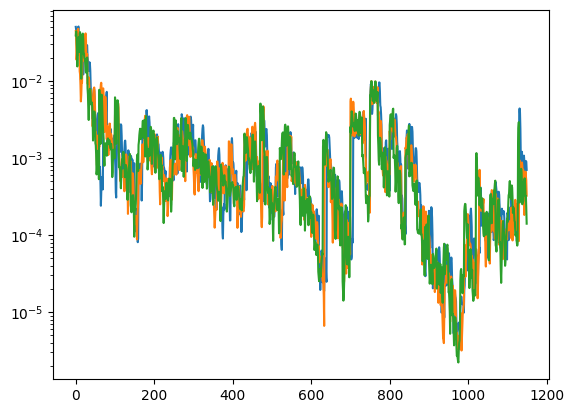

In [38]:
plt.plot(np.array([[l[3] for l in log] for log in logs[0:-1:3]]).reshape(-1))
# plt.plot(np.array([[l[-2] for l in log] for log in logs[0:-1:3]]).reshape(-1))

plt.plot(np.array([[l[3] for l in log] for log in logs[1:-1:3]]).reshape(-1))
# plt.plot(np.array([[l[-2] for l in log] for log in logs[1:-1:3]]).reshape(-1))

plt.plot(np.array([[l[3] for l in log] for log in logs[2:-1:3]]).reshape(-1))
# plt.plot(np.array([[l[-2] for l in log] for log in logs[2:-1:3]]).reshape(-1))

plt.yscale('log')

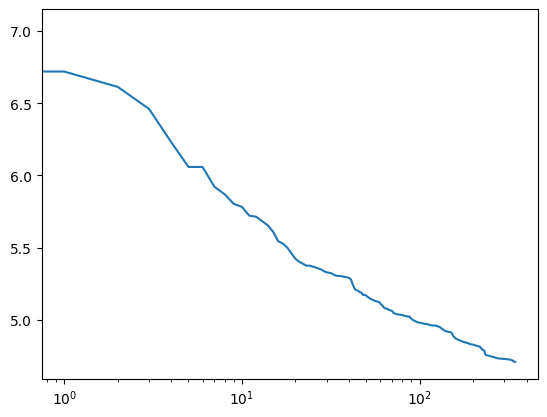

In [39]:
plt.plot(np.array([[p.mean(1).min() for p in f] for f in fs[:]]))
plt.xscale('log')

In [12]:
bestN = lambda N: np.concatenate([np.apply_along_axis(lambda x: (x),1, p.get_x()[np.argsort(p.get_f()[:,0])[:N],:]) for p in pops])

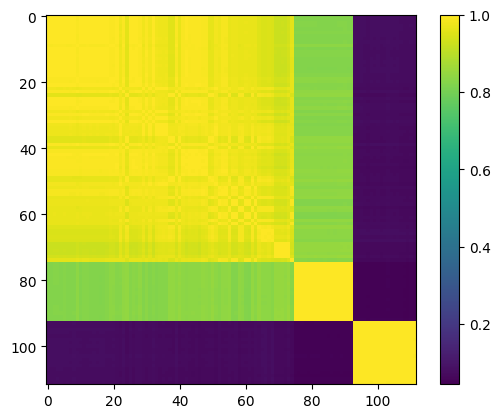

In [40]:
plt.imshow(np.corrcoef(bestN(112)))
plt.colorbar()

In [14]:
bestN = lambda N: np.concatenate([np.apply_along_axis(lambda x: (x),1, p.get_x()[np.argsort(p.get_f()[:,0])[:N],:]) for p in pops])
sampleM_fromN = lambda M,N: [np.random.multivariate_normal(np.mean(bestN(N),0),np.cov(bestN(N),rowvar=False)) for i in range(M)]

In [15]:
X = sampleM_fromN(10,112)

In [41]:
all_test = []
all_results_df = []
all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate(bestN(4)):
    if test_myprob.scale: x = test_myprob._unscale(c)
    if test_myprob.log: x = np.array([10**v if k else v for k,v in zip(test_myprob.log,x)])
    test_res = test_myprob._simulate(x)
    # train_res = train_myprob._simulate(10**uc)
    # [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
    all_test.append(test_res)

    # print(test_myprob.fitness(c))

    compiled_results = {}
    ms = test_myprob.model_stuff[0]
    k = 0
    prev_i = None
    for i, s in zip(test_index_map['index'],test_index_map['sample']):
        if prev_i is not None:
            if i != prev_i:
                k = 0
        compiled_results[s] = all_test[-1][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
        k = k+1
        prev_i = i
    results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
    results_df.columns = ['sample', *ms.species_labels[ms.cols[i]]]
    results_df = results_df.set_index('sample')
    all_results_df.append(results_df)

In [42]:
all_test2 = []
all_results_df2 = []
all_results2 = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate(X):
    if test_myprob.scale: x = test_myprob._unscale(c)
    if test_myprob.log: x = np.array([10**v if k else v for k,v in zip(test_myprob.log,x)])
    test_res = test_myprob._simulate(x)
    # train_res = train_myprob._simulate(10**uc)
    # [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
    all_test2.append(test_res)

    # print(test_myprob.fitness(c))

    compiled_results = {}
    ms = test_myprob.model_stuff[0]
    k = 0
    prev_i = None
    for i, s in zip(test_index_map['index'],test_index_map['sample']):
        if prev_i is not None:
            if i != prev_i:
                k = 0
        compiled_results[s] = all_test2[-1][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
        k = k+1
        prev_i = i
    results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
    results_df.columns = ['sample', *ms.species_labels[ms.cols[i]]]
    results_df = results_df.set_index('sample')
    all_results_df2.append(results_df)

In [43]:
rand = pg.batch_random_decision_vector(test_prob, 10).reshape(10,-1)#[:,:-1]

all_test3 = []
all_results_df3 = []
all_results3 = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate(rand):
    if test_myprob.scale: x = test_myprob._unscale(c)
    if test_myprob.log: x = np.array([10**v if k else v for k,v in zip(test_myprob.log,x)])
    test_res = test_myprob._simulate(x)
    # train_res = train_myprob._simulate(10**uc)
    # [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
    all_test3.append(test_res)

    # print(test_myprob.fitness(c))

    compiled_results = {}
    ms = test_myprob.model_stuff[0]
    k = 0
    prev_i = None
    for i, s in zip(test_index_map['index'],test_index_map['sample']):
        if prev_i is not None:
            if i != prev_i:
                k = 0
        compiled_results[s] = all_test3[-1][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
        k = k+1
        prev_i = i
    results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
    results_df.columns = ['sample', *ms.species_labels[ms.cols[i]]]
    results_df = results_df.set_index('sample')
    all_results_df3.append(results_df)

CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (2000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, 

In [26]:
from sklearn.metrics import root_mean_squared_error

In [270]:
for k in range(13):
    mape0 = (mean_absolute_percentage_error(np.log10(test_data_df.set_index('sample')).values[:,k], np.mean(np.log10(all_results_df3)[:,:,k],0), sample_weight = ((test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,test_myprob.model_stuff[0].data_cols[5][k]].values.flatten()))))
    mape1 = (mean_absolute_percentage_error(np.log10(test_data_df.set_index('sample')).values[:,k], np.mean(np.log10(all_results_df2)[:,:,k],0), sample_weight = ((test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,test_myprob.model_stuff[0].data_cols[5][k]].values.flatten()))))
    print(mape1)

2.157834847406056
10.945165404970938
0.4552227812699569
2.653387354781607
0.7253029230205957
1.1118655114763556
1.5711945509011052
0.5014869937115131
0.18589583553582076
0.3508233293990768
1.430329116092195
1.1330025667105668
0.46060675385774386


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9beff09280>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9beff097c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9beff77fa0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9beff09be0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9beff09e80>,
 'means': []}

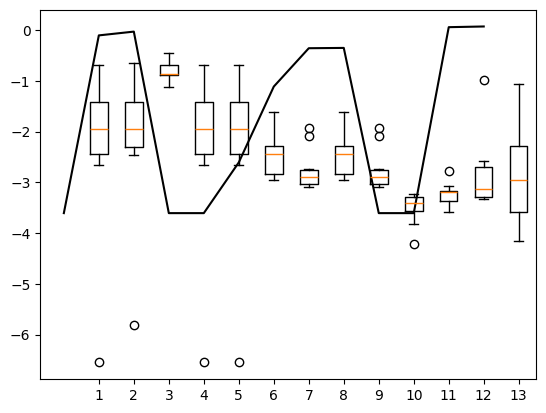

In [76]:
k = 1
plt.plot(np.log10(test_data_df.set_index('sample')).values[:,k],'k')
plt.boxplot((np.log10(all_results_df2)[:,:,k]))

In [329]:
test_index_map['sample']

0           gly_0
1          gly_30
2         gly_120
3         gly_240
4         gly_480
5           mal_0
6          mal_30
7          mal_60
8         mal_120
9         mal_240
10        mal_480
11          pyr_0
12         pyr_30
13         pyr_60
14        pyr_120
15        pyr_240
16        pyr_480
17          ser_0
18         ser_30
19         ser_60
20        ser_120
21        ser_240
22        ser_480
23        empty_0
24       empty_30
25       empty_60
26      empty_120
27      empty_240
28      empty_480
29            pyc
30        pyc_dil
31        pyc_HCT
32    pyc_HCT_dil
33         tdcb-0
34         tdcb-1
35         tdcb-2
36         tdcb-3
37          pyc-0
38          pyc-1
39          pyc-2
40          pyc-3
41          mdh-0
42          mdh-1
43          mdh-2
44          mdh-3
Name: sample, dtype: object

([], [])

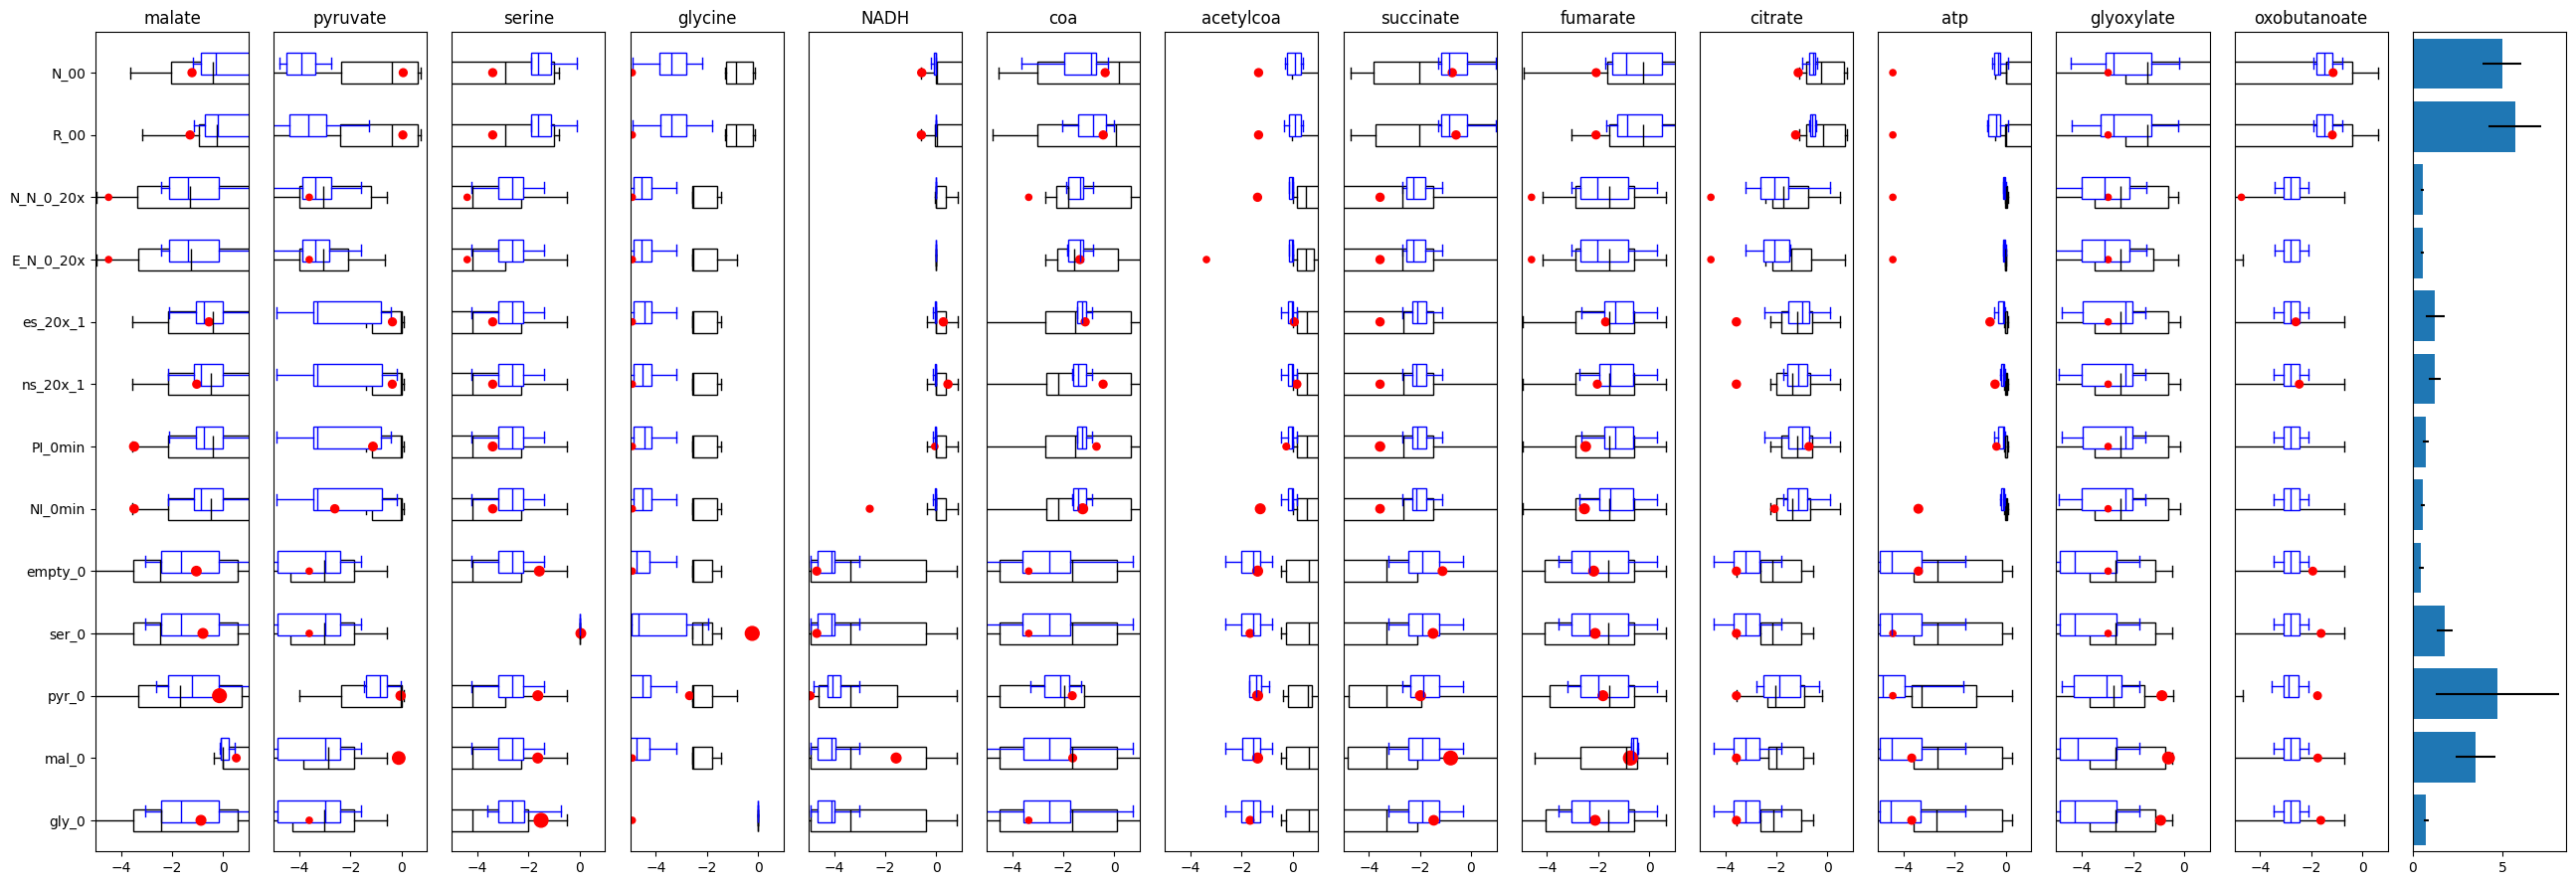

In [44]:
from sklearn.metrics import mean_absolute_percentage_error
plt.figure(figsize=(26,9))
for k in range(13):
        plt.subplot(1,14,k+1)

        box3 = plt.boxplot(np.log10(all_results_df3)[:,:,k], vert = False, positions = np.arange(1,1+len(all_results_df3[0])), notch = False, showfliers = False,  widths = 0.35, patch_artist=True)
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                plt.setp(box3[item], color='k')
        plt.setp(box3["boxes"], facecolor='w')

        #box1 = plt.boxplot(np.log10(all_results_df)[:,:,k], vert = False, positions = np.arange(1,14)-0.15, notch = False, showfliers = False,  widths = 0.35, patch_artist=True)
        #for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        #        plt.setp(box1[item], color='r')
        #plt.setp(box1["boxes"], facecolor='w')

        box2 = plt.boxplot(np.log10(all_results_df2)[:,:,k], vert = False, positions = np.arange(1,1+len(all_results_df2[0]))+0.15, notch = False, showfliers = False,  widths = 0.35, patch_artist=True)
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                plt.setp(box2[item], color='b')
        plt.setp(box2["boxes"], facecolor='w')

        # mape1 = (mean_absolute_percentage_error(np.log10(test_data_df.set_index('sample')).values[:,k], np.mean(np.log10(all_results_df2)[:,:,k],0), sample_weight = ((test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,test_myprob.model_stuff[0].data_cols[5][k]].values.flatten()))))

        plt.title(test_weights_df.drop(columns=['sample'], inplace=False).columns[test_myprob.model_stuff[0].data_cols[5][k]])
        plt.yticks(range(1,1+len(all_results_df2[0])), test_index_map['sample'].values, rotation = 0) if k == 0 else plt.yticks([])

        plt.scatter(np.log10(test_data_df.set_index('sample')).values[:,k], range(1,1+len(test_data_df)), s = ((test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,test_myprob.model_stuff[0].data_cols[5][k]].values.flatten()))*50, color = 'r', zorder = 2)
        plt.xlim([-5,1])
plt.tight_layout()

sample_mape = [np.mean([mean_absolute_percentage_error(np.log10(test_data_df.set_index('sample')).values[k,test_myprob.model_stuff[0].data_cols[5]], (np.log10(all_results_df2)[i,k,:])) for i in range(10)]) for k in range(13)]
sample_mape_std = [np.std([mean_absolute_percentage_error(np.log10(test_data_df.set_index('sample')).values[k,test_myprob.model_stuff[0].data_cols[5]], (np.log10(all_results_df2)[i,k,:])) for i in range(10)]) for k in range(13)]
plt.subplot(1,14,14)
plt.barh(range(13),sample_mape, xerr = sample_mape_std)
plt.ylim(-0.5,12.5)
plt.yticks([])

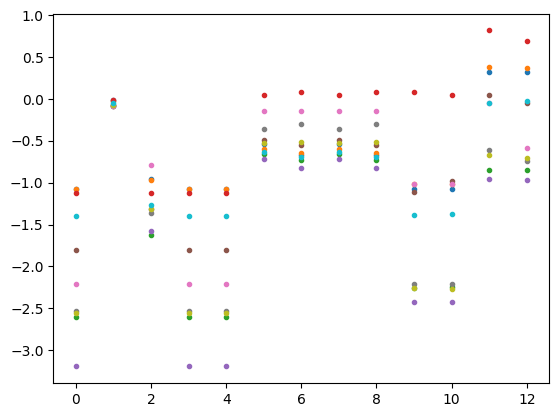

In [202]:
plt.plot(np.log10(all_results_df2)[:,:,0].T,'.')


array([[9.83069805e-01, 2.22886310e-01, 4.54257621e-01, 8.05327612e-01,
        7.50090268e-02, 9.34414057e-01, 6.99968348e-01, 6.19601937e-01,
        1.01816687e-01, 6.42383418e-02, 6.32643378e-01, 7.63815904e-01,
        7.31378755e-01, 8.18588623e-01, 5.50305916e-01, 4.40041158e-01,
        5.10945124e-01, 2.52667843e-01, 6.77044279e-01, 1.27609890e-01,
        2.63617265e-01, 8.97822219e-01, 3.66508187e-01, 7.43277001e-01,
        1.75542641e-01, 3.56236713e-01, 2.66382673e-01, 8.49360819e-01,
        3.52836585e-01, 6.40740775e-01, 8.33004020e-01, 4.73557803e-01,
        5.45917910e-01, 2.05224264e-01, 3.70130612e-01, 7.46486707e-01,
        8.52750968e-01, 6.08205624e-01, 5.94281546e-01, 2.06038056e-01,
        2.19027091e-02, 5.23768730e-01, 4.93518979e-01, 3.46218935e-02,
        6.13779402e-01, 2.64647895e-01, 2.63167891e-01, 5.12950993e-01,
        9.51443532e-01, 1.88212110e-02, 2.68723051e-01, 5.66416868e-01,
        5.33252984e-01, 3.76726405e-01, 1.47868713e-01, 6.814001

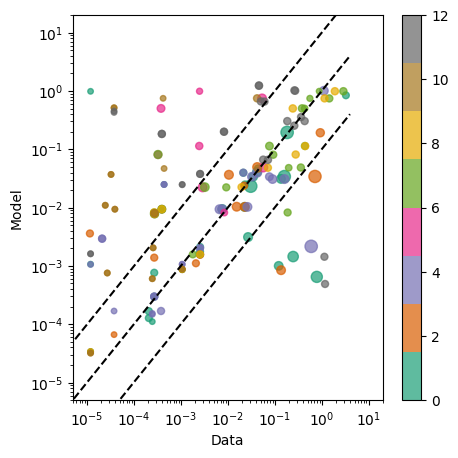

In [22]:
for rdf in [np.mean(all_results_df,0)]:#, np.mean(all_results_df2,0), np.mean(all_results_df3,0)]:
    plt.figure(figsize=(5,5))
    plt.scatter(test_data_df[all_results_df[0].columns].values.flatten(), 
                rdf.flatten(), 
                s = ((test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,test_myprob.model_stuff[0].data_cols[5]].values.flatten()))*40, 
                alpha=0.7, 
                c = (test_index_map['index'].values[np.newaxis].T*np.ones((len(rdf),len(all_results_df[0].columns)))).flatten(), cmap = 'Dark2')

    plt.xlabel('Data')
    plt.ylabel('Model')
    plt.plot([0,4],[0,4],'k--')
    plt.plot([0,4],[0,40],'k--')
    plt.plot([0,4],[0,0.40],'k--')
    plt.yscale('log')
    plt.xscale('log')
    plt.colorbar()
    plt.ylim([5e-6,20])
    plt.xlim([5e-6,20])

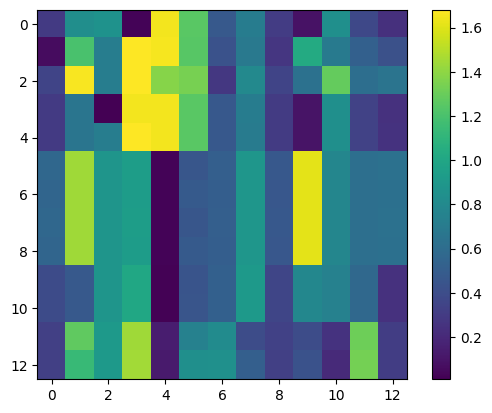

In [23]:
plt.imshow(np.std(all_results_df,0)/np.mean(all_results_df,0))
plt.colorbar()

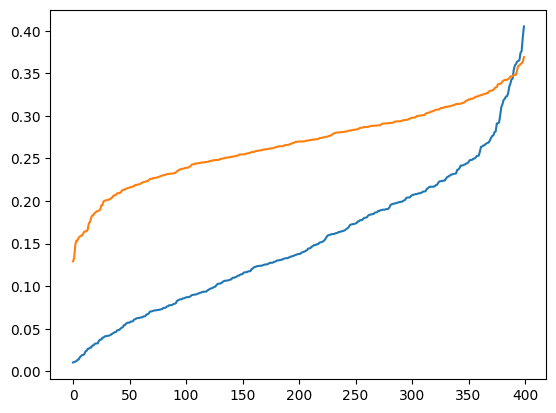

In [202]:
plt.plot(np.sort(bestN(4).std(0)))
plt.plot(np.sort(rand.std(0)))

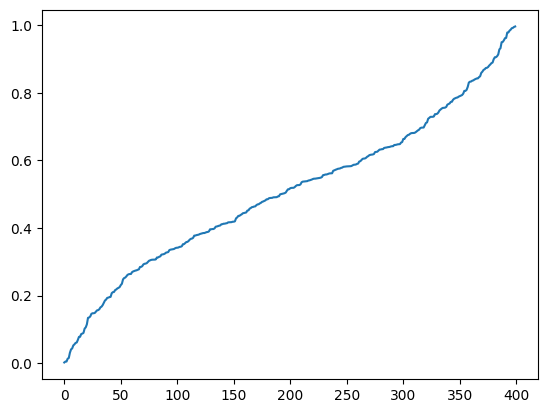

In [212]:
plt.plot(np.sort(pops[0].champion_x))

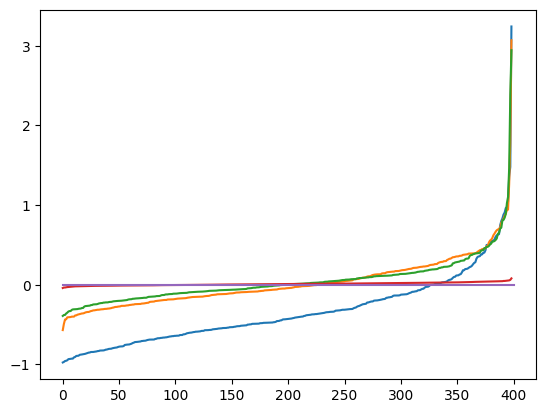

In [338]:
plt.plot(np.sort((bestN(4).std(0)-pops0[0].get_x().std(0))/pops0[0].get_x().std(0)))
plt.plot(np.sort((bestN(224).std(0)-pops0[0].get_x().std(0))/pops0[0].get_x().std(0)))
plt.plot(np.sort((bestN(2240).std(0)-pops0[0].get_x().std(0))/pops0[0].get_x().std(0)))
plt.plot(np.sort((pops0[1].get_x().std(0)-pops0[0].get_x().std(0))/pops0[0].get_x().std(0)))

plt.plot([0,400],[0,0])

In [339]:
np.array(parameter_labels)[np.argsort((bestN(224).std(0)-pops0[0].get_x().std(0))/pops0[0].get_x().std(0))[:100]]

array(['v509', 'Km_C00022_eEC2216', 'Km_C00531_eEC6215',
       'Km_C02876_eEC2721', 'rel3', 'v466', 'v224', 'v593', 'Keq_R60',
       'Km_C00084_eEC1111', 'Km_C06613_eEC1111', 'rel4', 'v160', 'v391',
       'Kcat_V_R174', 'Km_C00473_eEC1111', 'Km_C00011_eEC41149',
       'Km_C00026_eEC11142', 'v6', 'v295', 'Km_C00158_eEC4213', 'v263',
       'v501', 'Kcat_V_R346', 'Km_C00010_eEC1241', 'Kcat_V_R269', 'v712',
       'v577', 'Kcat_V_R172', 'Kcat_V_R372', 'v764', 'Km_C00080_eEC23112',
       'v37', 'Km_C00036_eEC2338', 'Km_C00010_eEC1242',
       'Km_C00469_eEC1112', 'v674', 'Km_C00080_eEC11140',
       'Km_C00311_eEC4213', 'Km_C00009_eEC6215', 'Kcat_V_R170',
       'Km_C00022_eEC23112', 'Km_C03451_eEC3126', 'Km_C00009_eEC2318',
       'Km_C00256_eEC11128', 'v265', 'Kcat_V_R86', 'v237', 'v325',
       'Km_C00101_eEC2121', 'Km_C00149_hEC11137', 'Km_C00003_hEC11719',
       'v373', 'Km_C00003_eEC1241', 'v658', 'v338', 'Km_C00080_eEC1242',
       'Kcat_V_R350', 'Km_C05577_eEC1111', 'Kcat_V_R

Text(0, 0.5, 'Glyoxylate (mM)')

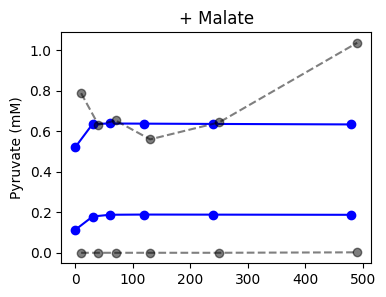

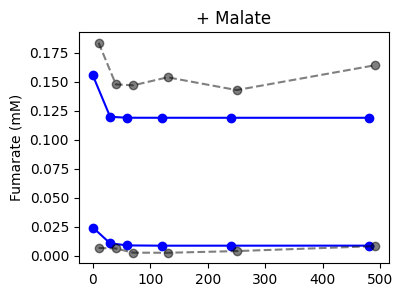

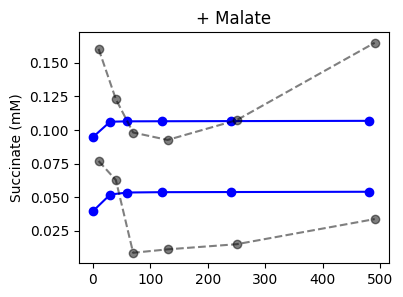

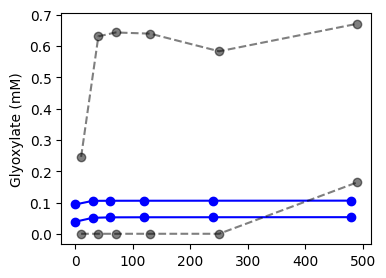

In [31]:
results = all_results_df[5]

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00022'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00022'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Pyruvate (mM)')
plt.title('+ Malate')

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00122'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00122'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00122'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00122'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Fumarate (mM)')
plt.title('+ Malate')

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00042'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00042'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00042'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00042'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Succinate (mM)')
plt.title('+ Malate')

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00048'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00048'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results.loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00048'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00048'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Glyoxylate (mM)')


In [43]:
scp = pg.algorithm(pg.scipy_optimize(method="Nelder-Mead"))
bestpop = pg.population(pg.problem(test_myprob), 0)
bestpop.push_back(pops[0].champion_x, pops[0].champion_f)

In [44]:
re = scp.evolve(bestpop)

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:609: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:625: RuntimeWarning:

Mean of empty slice.

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:96: UserWarning:


